## Feature Engineering Demos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

insurance_df = pd.read_csv("../Data/insurance.csv")

insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
def value_counter(dataframe):
    value_series = pd.DataFrame()
    for col in dataframe.select_dtypes(["object"]).columns:
        print(dataframe[col].value_counts())
             
value_counter(insurance_df)

sex
male      676
female    662
Name: count, dtype: int64
smoker
no     1064
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


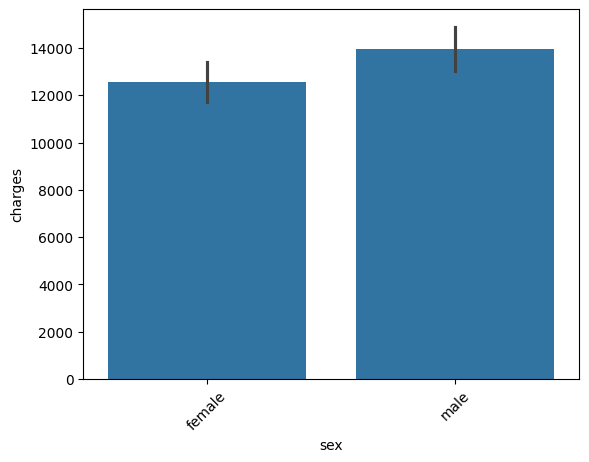

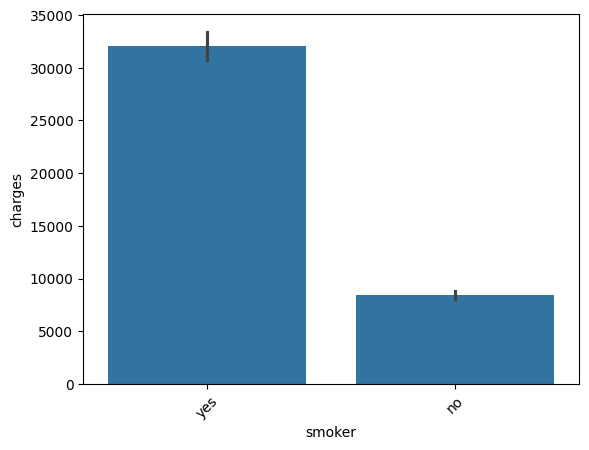

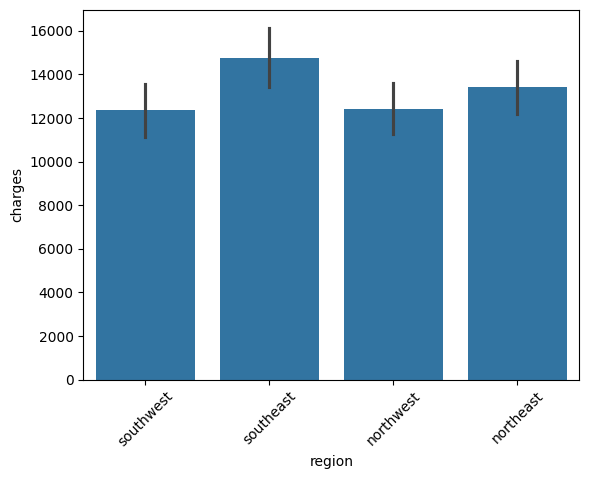

In [3]:
def cat_plotter(data, target):
    import matplotlib.pyplot as plt
    for col in data.select_dtypes(["object"]).columns:
        sns.barplot(data=data, x=col, y=target)
        plt.xticks(rotation=45)
        plt.show()
        
cat_plotter(insurance_df, "charges")

In [4]:
region_dict = {
    "northwest": "west",
    "southwest": "west",
    "northeast": "east",
    "southeast": "east",
}

insurance_df["region_group"] = insurance_df["region"].map(region_dict)

insurance_df["region_group"].value_counts()

east    688
west    650
Name: region_group, dtype: int64

In [5]:
insurance_df["has_child"] = np.where(insurance_df["children"] > 0, 1, 0)

insurance_df["has_child"].value_counts()

1    764
0    574
Name: has_child, dtype: int64

In [6]:
insurance_df = insurance_df.drop(["region", "sex"], axis=1)

In [7]:
from sklearn.model_selection import train_test_split


insurance_df = (
    pd.get_dummies(insurance_df, drop_first=True)
    .assign(
        age_sq = insurance_df["age"]**2,
#         smoker_bmi_int = lambda x: x["smoker_yes"] * x["bmi"]
           )
)

X = sm.add_constant(insurance_df.drop(["charges"], axis=1))
y = insurance_df["charges"]

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

X.head()

,const,age,bmi,children,has_child,smoker_yes,region_group_west,age_sq
1068,1.0,63,21.660,1,1,0,1,3969
1018,1.0,54,35.815,3,1,0,1,2916
995,1.0,39,23.275,3,1,0,0,1521
1248,1.0,18,39.820,0,0,0,0,324
549,1.0,43,46.200,0,0,1,0,1849


In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae


kf = KFold(n_splits=5, shuffle=True, random_state=2023)

# Create a list to store validation scores for each fold
cv_lm_r2s = []
cv_lm_mae = []

# Loop through each fold in X and y
for train_ind, val_ind in kf.split(X, y):
    # Subset data based on CV folds
    X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
    X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
    # Fit the Model on fold's training data
    model = sm.OLS(y_train, X_train).fit()
    # Append Validation score to list 
    cv_lm_r2s.append(r2(y_val, model.predict(X_val),))
    cv_lm_mae.append(mae(y_val, model.predict(X_val),))

print("All Validation R2s: ", [round(x, 3) for x in cv_lm_r2s])
print(f"Cross Val R2s: {round(np.mean(cv_lm_r2s), 3)} +- {round(np.std(cv_lm_r2s), 3)}")

print("All Validation MAEs: ", [round(x, 3) for x in cv_lm_mae])
print(f"Cross Val MAEs: {round(np.mean(cv_lm_mae), 3)} +- {round(np.std(cv_lm_mae), 3)}")

All Validation R2s:  [0.738, 0.755, 0.756, 0.773, 0.715]
Cross Val R2s: 0.747 +- 0.019
All Validation MAEs:  [4344.371, 3937.775, 4379.035, 3913.957, 4369.28]
Cross Val MAEs: 4188.884 +- 215.182


In [9]:
model = sm.OLS(y, X).fit()

# print(f"Test R2: {r2(y_test, model.predict(X_test))}")
# print(f"Test MAE: {mae(y_test, model.predict(X_test))}")

In [10]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     456.2
Date:                Wed, 23 Aug 2023   Prob (F-statistic):          7.84e-315
Time:                        14:01:01   Log-Likelihood:                -10849.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1062   BIC:                         2.175e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -6684.4343   1944.829     -3.437      0.001   -1.05e+04   -2868.290
age                 -67.6092     96.232     -0.703      0.482    -256.436     121.218
bmi                 314.5670     31.017     10.142      0.000     253.705     375.429
children            467.4102    255.387      1.830      0.067     -33.710     968.531
has_child           504.2557    636.562      0.792      0.428    -744.807    1753.319
smoker_yes         2.402e+04    468.787     51.236      0.000    2.31e+04    2.49e+04
region_group_west    98.5295    380.446      0.259      0.796    -647.981     845.041
age_sq                4.1558      1.200      3.464      0.001       1.802       6.510
==============================================================================
Omnibus:                      260.303   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              663.055
Skew:                           1.271   Prob(JB):                    1.05e-144
Kurtosis:                       5.899   Cond. No.                     2.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
orders = pd.DataFrame({
    "Customer_ID": [10001, 10001, 10002, 10002, 10003, 10004],
    "Order_Date": ["2023-01-25", "2023-06-13", "2023-02-02", "2023-02-02", "2023-05-15", "2023-02-17"],
    "Product_ID": ["GPQ-123", "QP3-111", "GPQ-123", "ACD-489", "GPQ-123", "QP3-123"],
    "Item_Price": [59.99, 79.99, 59.99, 19.99, 59.99, 79.99],
    "Quantity": [3, 5, 1, 2, 1, 4],
}).astype({"Order_Date": "datetime64"})

orders.head()

,Customer_ID,Order_Date,Product_ID,Item_Price,Quantity
0,10001,2023-01-25,GPQ-123,59.99,3
1,10001,2023-06-13,QP3-111,79.99,5
2,10002,2023-02-02,GPQ-123,59.99,1
3,10002,2023-02-02,ACD-489,19.99,2
4,10003,2023-05-15,GPQ-123,59.99,1


In [12]:
orders = orders.assign(
    total_value = orders["Item_Price"] * orders["Quantity"],
    days_since_last_purchase = (pd.Timestamp.today() - orders["Order_Date"]).dt.days,
)

orders.head()

,Customer_ID,Order_Date,Product_ID,Item_Price,Quantity,total_value,days_since_last_purchase
0,10001,2023-01-25,GPQ-123,59.99,3,179.97,210
1,10001,2023-06-13,QP3-111,79.99,5,399.95,71
2,10002,2023-02-02,GPQ-123,59.99,1,59.99,202
3,10002,2023-02-02,ACD-489,19.99,2,39.98,202
4,10003,2023-05-15,GPQ-123,59.99,1,59.99,100


In [13]:
orders.groupby("Customer_ID").agg(
    total_items_sold = ("Quantity", "sum"),
    average_value = ("total_value", "mean")
)

,total_items_sold,average_value
Customer_ID,,
10001,8,289.960
10002,3,49.985
10003,1,59.990
10004,4,319.960


In [15]:
# def add_deviation_feature(X, feature, category):
    
#     # temp groupby object
#     category_gb = X.groupby(category)[feature]
    
#     # create columns of category means and standard deviations
#     category_mean = category_gb.transform(lambda x: x.mean())
#     category_std = category_gb.transform(lambda x: x.std())
    
#     # compute stds from category mean for each feature value,
#     # add to X as new feature
#     deviation_feature = (X[feature] - category_mean) / category_std 
#     X[feature + '_Dev_' + category] = deviation_feature


# add_deviation_feature(insurance_df, 'bmi', 'smoker')

insurance_df.tail()

,age,bmi,children,charges,has_child,smoker_yes,region_group_west,age_sq
1333,50,30.97,3,10600.5483,1,0,1,2500
1334,18,31.92,0,2205.9808,0,0,0,324
1335,18,36.85,0,1629.8335,0,0,0,324
1336,21,25.80,0,2007.9450,0,0,1,441
1337,61,29.07,0,29141.3603,0,1,1,3721
